In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
link='https://drive.google.com/open?id=1NOrtLjmCvURr5DpWjGSSNJRJTa__x8o_'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('stemmed.csv')

1NOrtLjmCvURr5DpWjGSSNJRJTa__x8o_


In [0]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("stemmed.csv", engine="python", index_col=0)
df.head()

,text,sentiment
0,awww that bummer shoulda got david carr third day,0
1,upset cant updat facebook text might cri resul...,0
2,dive mani time ball manag save rest go bound,0
3,whole bodi feel itchi like fire,0
4,no not behav im mad cant see,0


In [5]:
np.sum(df.isnull().any(axis=1))

6609

In [6]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1593391 entries, 0 to 1593390
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1593391 non-null  object
 1   sentiment  1593391 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.3+ MB


# Global Configuration

In [0]:
MAX_WORDS = 12
EMBEDDING_SIZE = 32
BATCH_SIZE = 5000
EPOCHS = 10
LSTM_CELLS = 32
LSTM_DROPOUT = 0.2
LSTM_RECURRENT_DROPOUT = 0.2
DROPOUT_AFTER_EMBEDDING = 0.2
VOCAB_SIZE = 25000


# Tokenization

In [0]:
x = df['text']
y = [1 if x == 4 else 0 for x in df['sentiment']]

In [9]:
from keras.preprocessing import sequence 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(x)
x = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=MAX_WORDS, padding="post")

vocab_size = len(tokenizer.word_index) + 1
print('vocab size is : ', vocab_size)



Using TensorFlow backend.


vocab size is :  369217


In [10]:
total_words = 0
for rev in df['text']:
  total_words += len(rev.split())

print("words/review average : ", total_words/1600000)

words/review average :  7.2457475


# Neural Network


In [11]:
# Build the model
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from keras import optimizers
from keras import regularizers

model=Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_WORDS))
if DROPOUT_AFTER_EMBEDDING!=0:
  model.add(Dropout(DROPOUT_AFTER_EMBEDDING))
model.add(LSTM(LSTM_CELLS, dropout=LSTM_DROPOUT, return_sequences = True, recurrent_dropout=LSTM_RECURRENT_DROPOUT))
model.add(LSTM(LSTM_CELLS, dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_RECURRENT_DROPOUT))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 32)            11814944  
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,831,617
Trainable params: 11,831,617
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [13]:
hist = model.fit(xTrain, yTrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, shuffle=True, validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1290645 samples, validate on 143406 samples
Epoch 1/10
1290645/1290645 [==============================] - 167s 129us/step - loss: 0.5122 - acc: 0.7425 - val_loss: 0.4534 - val_acc: 0.7872
Epoch 2/10
1290645/1290645 [==============================] - 165s 128us/step - loss: 0.4501 - acc: 0.7904 - val_loss: 0.4435 - val_acc: 0.7928
Epoch 3/10
1290645/1290645 [==============================] - 167s 129us/step - loss: 0.4393 - acc: 0.7957 - val_loss: 0.4408 - val_acc: 0.7952
Epoch 4/10
1290645/1290645 [==============================] - 167s 129us/step - loss: 0.4328 - acc: 0.7990 - val_loss: 0.4387 - val_acc: 0.7976
Epoch 5/10
1290645/1290645 [==============================] - 167s 129us/step - loss: 0.4266 - acc: 0.8025 - val_loss: 0.4359 - val_acc: 0.7996
Epoch 6/10
1290645/1290645 [==============================] - 167s 129us/step - loss: 0.4217 - acc: 0.8052 - val_loss: 0.4339 - val_acc: 0.8011
Epoch 7/10
1290645/1290645 [==============================] - 167s 129us/step - los

# Analyzing the results


## Test prediction


In [14]:
results = model.evaluate(xTest, yTest, batch_size=1024)
print('test loss, test acc:', results)

159340/159340 [==============================] - 5s 34us/step
test loss, test acc: [0.430954546733589, 0.8033450245857239]


## Epoch plot


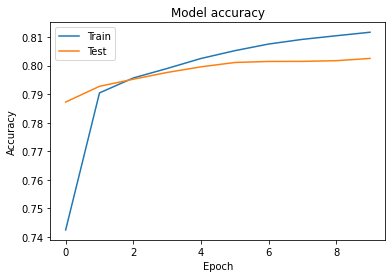

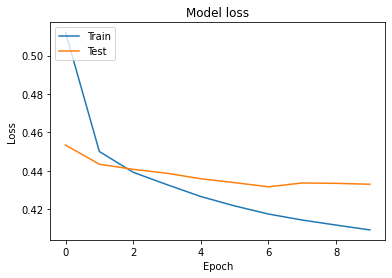

In [15]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show() 


## Actual predictions




In [16]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))- set(['no', 'not', 'nor'])
stemmer =  SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def advanced_cleaning(text):
  text = text.split()
  # Remove stopwords
  text = [word for word in text if not word in stop_words]
  # Stem
  text = [stemmer.stem(word) for word in text]
  return ' '.join(text)

In [18]:
test_1 = "my favorite service out there i am simply in love with this"
test_2 = "good service personel is friendly and good job"
test_3 = "better than a lot of its competitors but a little bit under my expectations satisfying altogether"
test_4 = "maybe I like this service I am still not sure"
test_5 = "not the kind of service I would pay for but definetly something to keep a close eye on"
test_6 = "i am a little disappointed by this service"
test_7 = "not a good service very bad team abysmal experience what do u have exactly"
test_8 = "so bad absolutely one of the worst"
test_9 = "why all these bad predictions i can't understand"

test_samples = [test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9]
test_samples = [advanced_cleaning(text) for text in test_samples]
test_samples_tokens = tokenizer.texts_to_sequences(test_samples)

predicted_tokenized = pad_sequences(test_samples_tokens, maxlen=MAX_WORDS, padding='post')
print(model.predict(predicted_tokenized))

print(model.predict_classes(predicted_tokenized))

[[0.9918061 ]
 [0.98410887]
 [0.9901308 ]
 [0.34952867]
 [0.274893  ]
 [0.05516914]
 [0.35810512]
 [0.04100516]
 [0.05093192]]
[[1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
